In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif


/var/folders/ct/fjh_5m0n2zj9r5lpl1nrd20m0000gn/T/ipykernel_47641/3880567764.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [40]:
import copy


class DataAnalyzer:
    def __init__(self):
        file_path = 'CancerMB.csv'

        self.dataset = pd.read_csv(file_path, header=None)
        self.dataset.columns = self.dataset.iloc[0]

        self.dataset = self.dataset.drop(0)
        self.dataset = self.dataset.drop(self.dataset.columns[0], axis=1)
        self.original_dataset = self.dataset
        self.fill_nan_vals()
        # print(self.dataset.shape[1])
        self.dataset = self.dataset.dropna(axis=1)
        # print(self.dataset.shape[1])
        self.encode_categorical()

  
    def fill_nan_vals(self):
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Non-numerical column
                mode_val = self.dataset[column].mode()[0]
                self.dataset[column] = self.dataset[column].fillna(mode_val)
            else:  # Numerical column
                mean_val = self.dataset[column].mean()
                self.dataset[column] = self.dataset[column].fillna(mean_val)

    def drop_nan_vals(self):
        self.dataset = self.dataset.dropna()
        
    def encode_categorical(self):
        label_encoder = LabelEncoder()
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Check if column is categorical
                encoded_values = label_encoder.fit_transform(self.dataset[column])
                self.dataset.loc[:, column] = encoded_values


    def show_boxplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=5, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.boxplot(y=k, data=self.dataset, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_outlier_percs(self):
        for k, v in self.dataset.items():
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(self.dataset)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    def remove_outliers(self):
        self.dataset = self.dataset[~((self.dataset['stage'] > 7.0) | (self.dataset['stage'] < 4.0))]
        return self.dataset

    def normalize_df_by_max(self):
        columns_to_exclude=['diagnosis', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
        normalized_df = self.dataset.copy()
        for column in self.dataset.columns:
            if column not in columns_to_exclude:
                max_abs_value = abs(self.dataset[column]).max()
                normalized_df[column] = self.dataset[column] / max_abs_value

        self.dataset = normalized_df
        return self.dataset

    def normalize_df_by_mean(self):
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test_final = sc.transform(self.X_test_final)
        if self.X_cv is not None:
            self.X_cv = sc.fit_transform(self.X_cv)
        return(self.X_train, self.X_test_final, self.X_cv)
    
    def show_histplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=5, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.histplot(v, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_heat_map(self):
        corr_matrix = self.dataset.corr()
        plt.figure(figsize=(20, 20))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix")
        plt.show()

    def perform_filter_methods(self):
        data = copy.deepcopy(self.dataset)
        X = copy.deepcopy(data).drop(columns=['diagnosis'])  # Features
        print("total features = ", len(X.columns))
        y = copy.deepcopy(data['diagnosis']).astype(int) 
        # Calculate Mutual Information scores
        mi_scores = mutual_info_classif(X, y)
        # Select features with MI score > 0.5
        selected_features = X.columns[mi_scores > 0.2]
        print("selected features with high mutual information with the target = ", len(selected_features))
        # Calculate correlation matrix
        corr_matrix = X[selected_features].corr().abs()
        # Remove one of two highly correlated features
        to_drop = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > 0.8:
                    colname_i = corr_matrix.columns[i]
                    colname_j = corr_matrix.columns[j]
                    # Calculate the Mutual Information score of each feature with the target variable
                    mi_i = mutual_info_classif(X[colname_i].values.reshape(-1, 1), y)[0]
                    mi_j = mutual_info_classif(X[colname_j].values.reshape(-1, 1), y)[0]
                    # Keep the feature with higher Mutual Information score
                    if mi_i > mi_j:
                        to_drop.add(colname_j)
                    else:
                        to_drop.add(colname_i)
        final_selected_features = selected_features.drop(to_drop)
        print("final selected features after removing one of two correlated features = ", len(final_selected_features))
        self.dataset = self.dataset[final_selected_features]
        self.dataset["diagnosis"] = data["diagnosis"]
        return self.dataset

    def plot_variations(self):
        min_max_scaler = preprocessing.MinMaxScaler()
        column_sels = self.dataset.columns
        x = self.dataset.loc[:,column_sels]
        y = self.dataset['diagnosis']
        # x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
        fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for i, k in enumerate(column_sels):
            sns.regplot(y=y, x=x[k], ax=axs[i])
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    
    def get_x_and_Y(self):
        self.X = self.dataset.drop('diagnosis', axis=1)  # Assuming 'p' is the target variable
        self.y = self.dataset['diagnosis']
        return (self.X, self.y)
    
    def perform_manual_splitting_cv(self):
        # First split to get training set and first test set
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(self.X, self.y, test_size=0.4, random_state=0)
        self.y_train = self.y_train.astype(int)
        y_temp =  y_temp.astype(int)

        # Second split to further split the temporary test set into the second test set
        self.X_cv, self.X_test_final, self.y_cv, self.y_test_final = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
        self.y_cv = self.y_cv.astype(int)
        self.y_test_final = self.y_test_final.astype(int)

    def perform_manual_splitting_without_cv(self):
        # First split to get training set and first test set
        self.X_train, self.X_test_final, y_train, y_temp = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        self.y_train = y_train.astype(int)
        self.y_test_final = y_temp.astype(int)

    def perform_knn_without_cv(self):
        self.classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2.7)
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_test_final)
        self.ac_final = accuracy_score(self.y_test_final,y_pred1)
        return self.ac_final
        

    def perform_knn(self):
        self.classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2.7)
        self.classifier.fit(self.X_train, self.y_train)
        y_pred1 = self.classifier.predict(self.X_cv)
        self.ac_cv = accuracy_score(self.y_cv,y_pred1)
        return self.ac_cv

    def get_accuracy(self):
        y_pred_final = self.classifier.predict(self.X_test_final)
        self.ac_final = accuracy_score(self.y_test_final,y_pred_final)
        return self.ac_final

    
    def perform_kfold_cv(self):
        X_train, X_test_final, y_train, y_test_final = train_test_split(self.X, self.y, test_size=0.2, random_state=0)
        self.X_train = X_train
        self.y_train = y_train.astype(int)
        self.X_test_final = X_test_final.reindex(X_train.columns, axis=1)
        self.y_test_final = y_test_final.astype(int)
        classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)

        # Perform k-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=0)

        scores = []
        best_model = None
        best_avg_score = 0.0 

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index].astype(int), y_train.iloc[val_index].astype(int)

            # Train the model on the training fold
            classifier.fit(X_train_fold, y_train_fold)

            # Evaluate the model on the validation fold
            score = classifier.score(X_val_fold, y_val_fold)

            # Update the best model if the current model has a better average performance
            if score > best_avg_score:
                best_avg_score = score
                best_model = classifier
            scores.append(score)
        
        self.classifier = best_model
        return(best_avg_score, scores)

class Master:
    def __init__(self):
        self.results = {}
        
    def organize_results(self):
        items = []
        for k, v in self.results.items():
            print(k, v)
            if isinstance(v, dict):
                for xk, xv in v.items():
                    new_x_key = xk
                    items.append((new_x_key, xv))
            else:
                new_key = k
                items.append((new_key, v))
        r_items = dict(items)
        df = pd.DataFrame({'method': list(r_items.keys()), 'result': list(r_items.values())})
        return df

    def run_without_cv(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_without_cv()
        rslts = anlyzr.perform_knn_without_cv()
        self.results["run without cv"] = rslts

    def run_with_cv(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["run with cv"] = anlyzr.get_accuracy()

    def run_with_kfold(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        (best_avg_score, scores) = anlyzr.perform_kfold_cv()
        self.results["after_k_fold_run"] = {
            "best kfold cv score": best_avg_score,
            "scores": scores,
            "final kfold score on test dataset": anlyzr.get_accuracy()
        }

    def run_with_filter(self):
        # Implement feature selection using filter method (e.g., correlation)
        anlyzr = DataAnalyzer()
        anlyzr.perform_filter_methods()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        anlyzr.perform_knn()
        self.results["with_filter_method"] = anlyzr.get_accuracy()

    def run_with_wrapper(self):
        # Implement feature selection using wrapper method (e.g., recursive feature elimination)
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        # Apply wrapper-based feature selection
        # e.g., anlyzr.perform_wrapper_selection()
        anlyzr.perform_knn()
        self.results["with_wrapper_method"] = anlyzr.get_accuracy()

    def run_with_pca(self):
        # Implement feature selection using PCA
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.perform_manual_splitting_cv()
        # Apply PCA
        # e.g., anlyzr.perform_pca()
        anlyzr.perform_knn()
        self.results["with_pca"] = anlyzr.get_accuracy()
    
    def run(self):
        self.run_without_cv()
        self.run_with_cv()
        self.run_with_kfold()
        return self.results


In [41]:
mstr = Master()
# mstr.run()
# mstr.organize_results()

In [42]:
mstr.run_with_filter()
print(mstr.results)

total features =  30
selected features with high mutual information with the target =  15
final selected features after removing one of two correlated features =  9
{'with_filter_method': 0.8947368421052632}


In [38]:
anlyzr = DataAnalyzer()

31


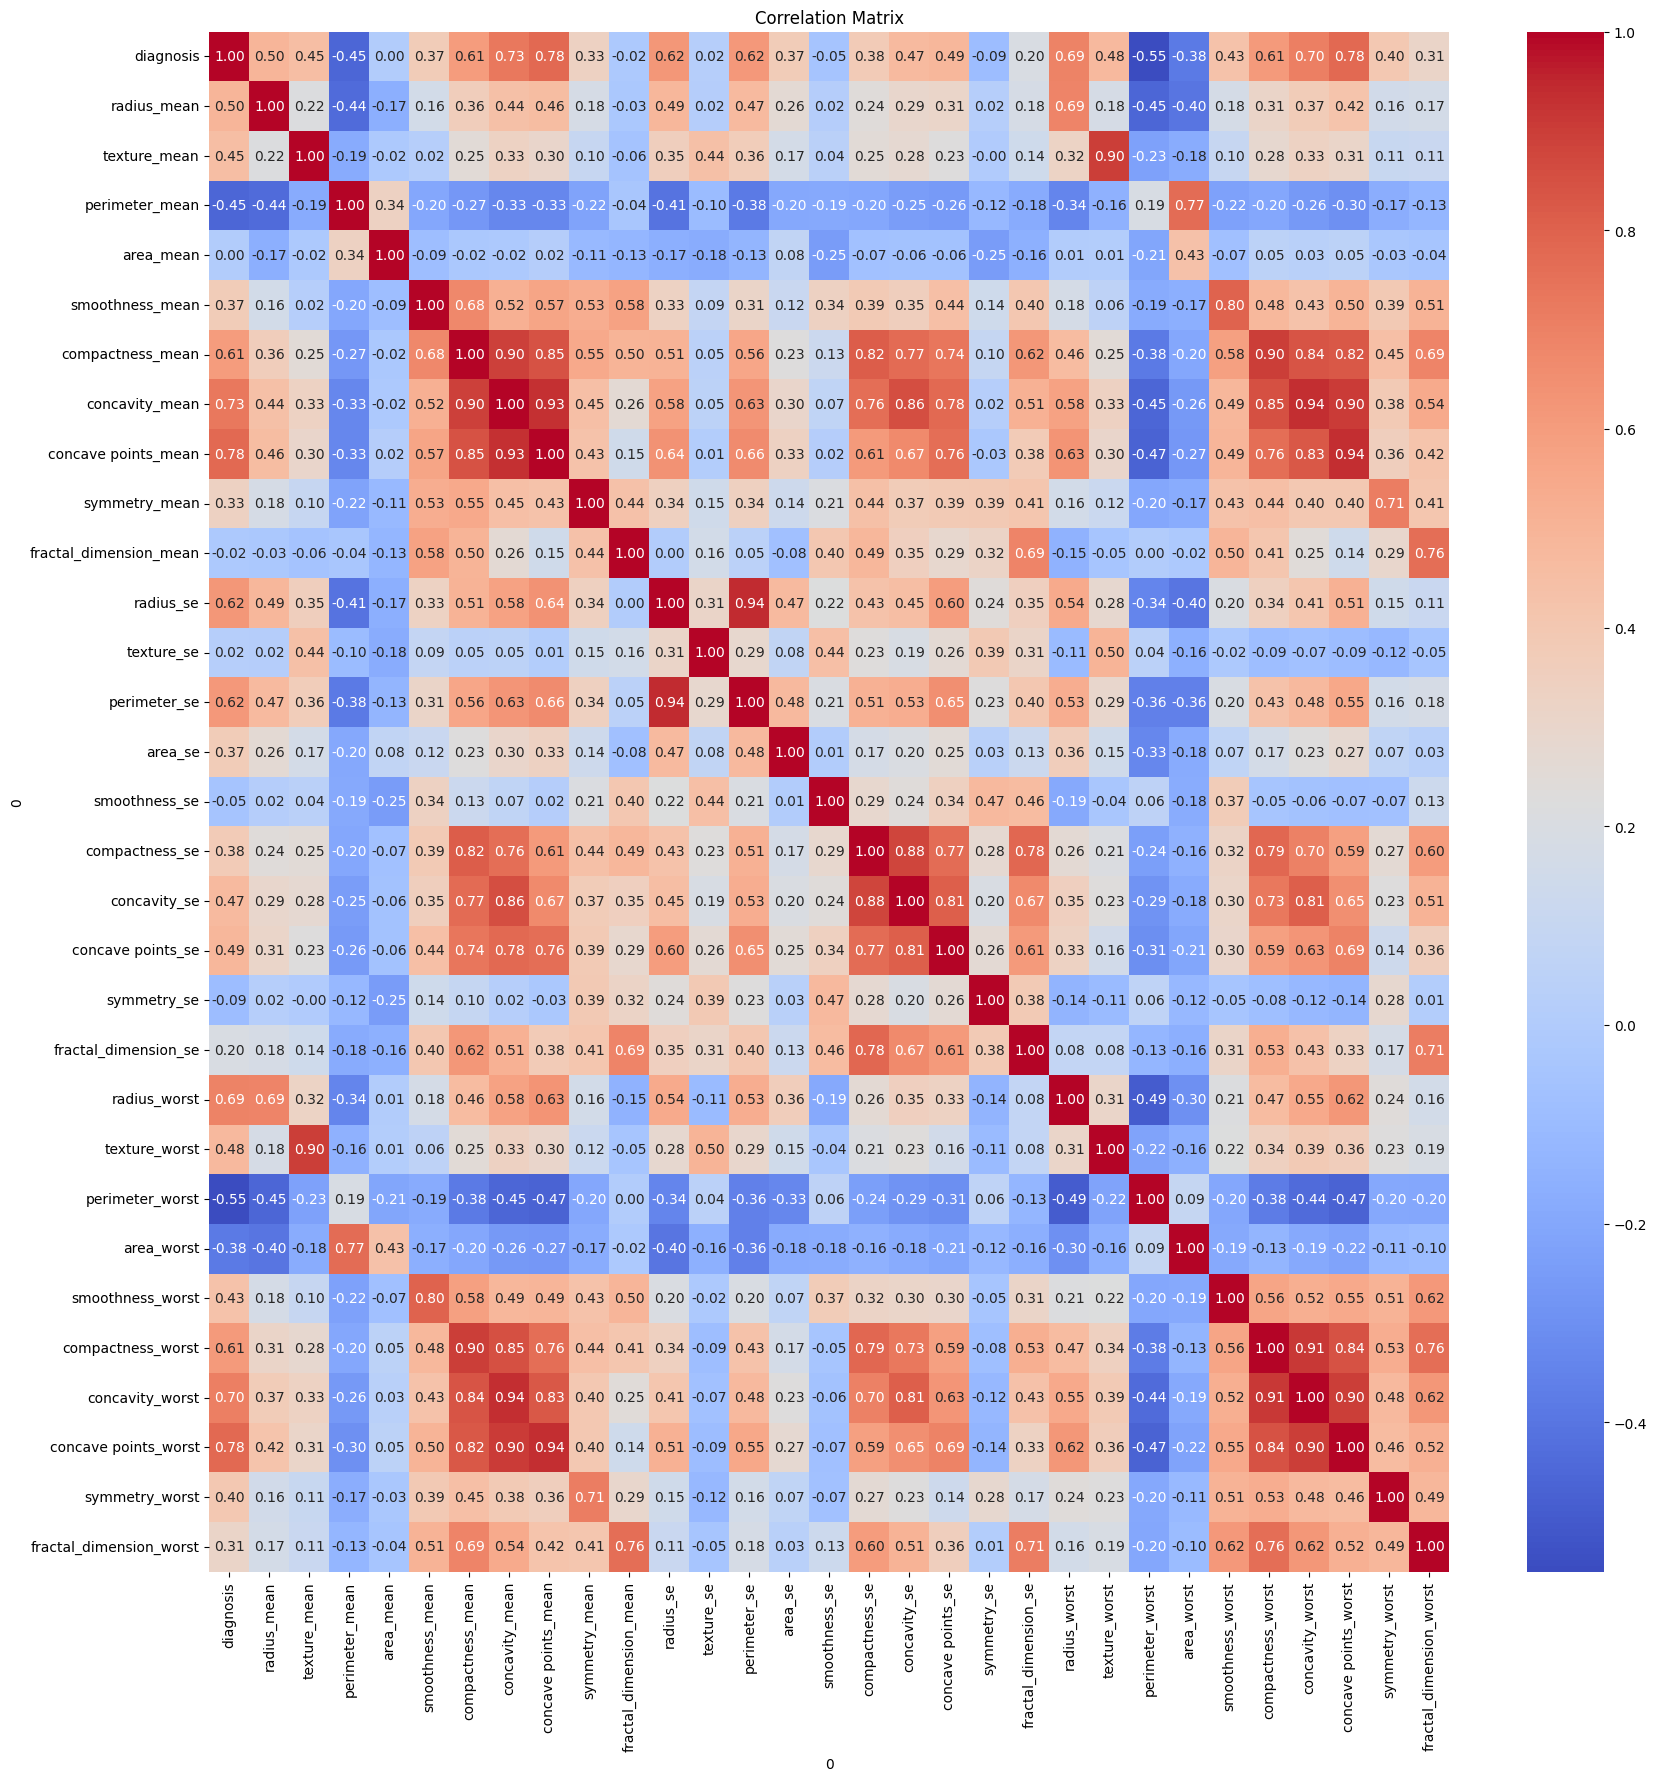

In [51]:
print(anlyzr.dataset.shape[1])
anlyzr.show_heat_map()

total features =  30
selected features with high mutual information with the target =  15
final selected features after removing one of two correlated features =  9


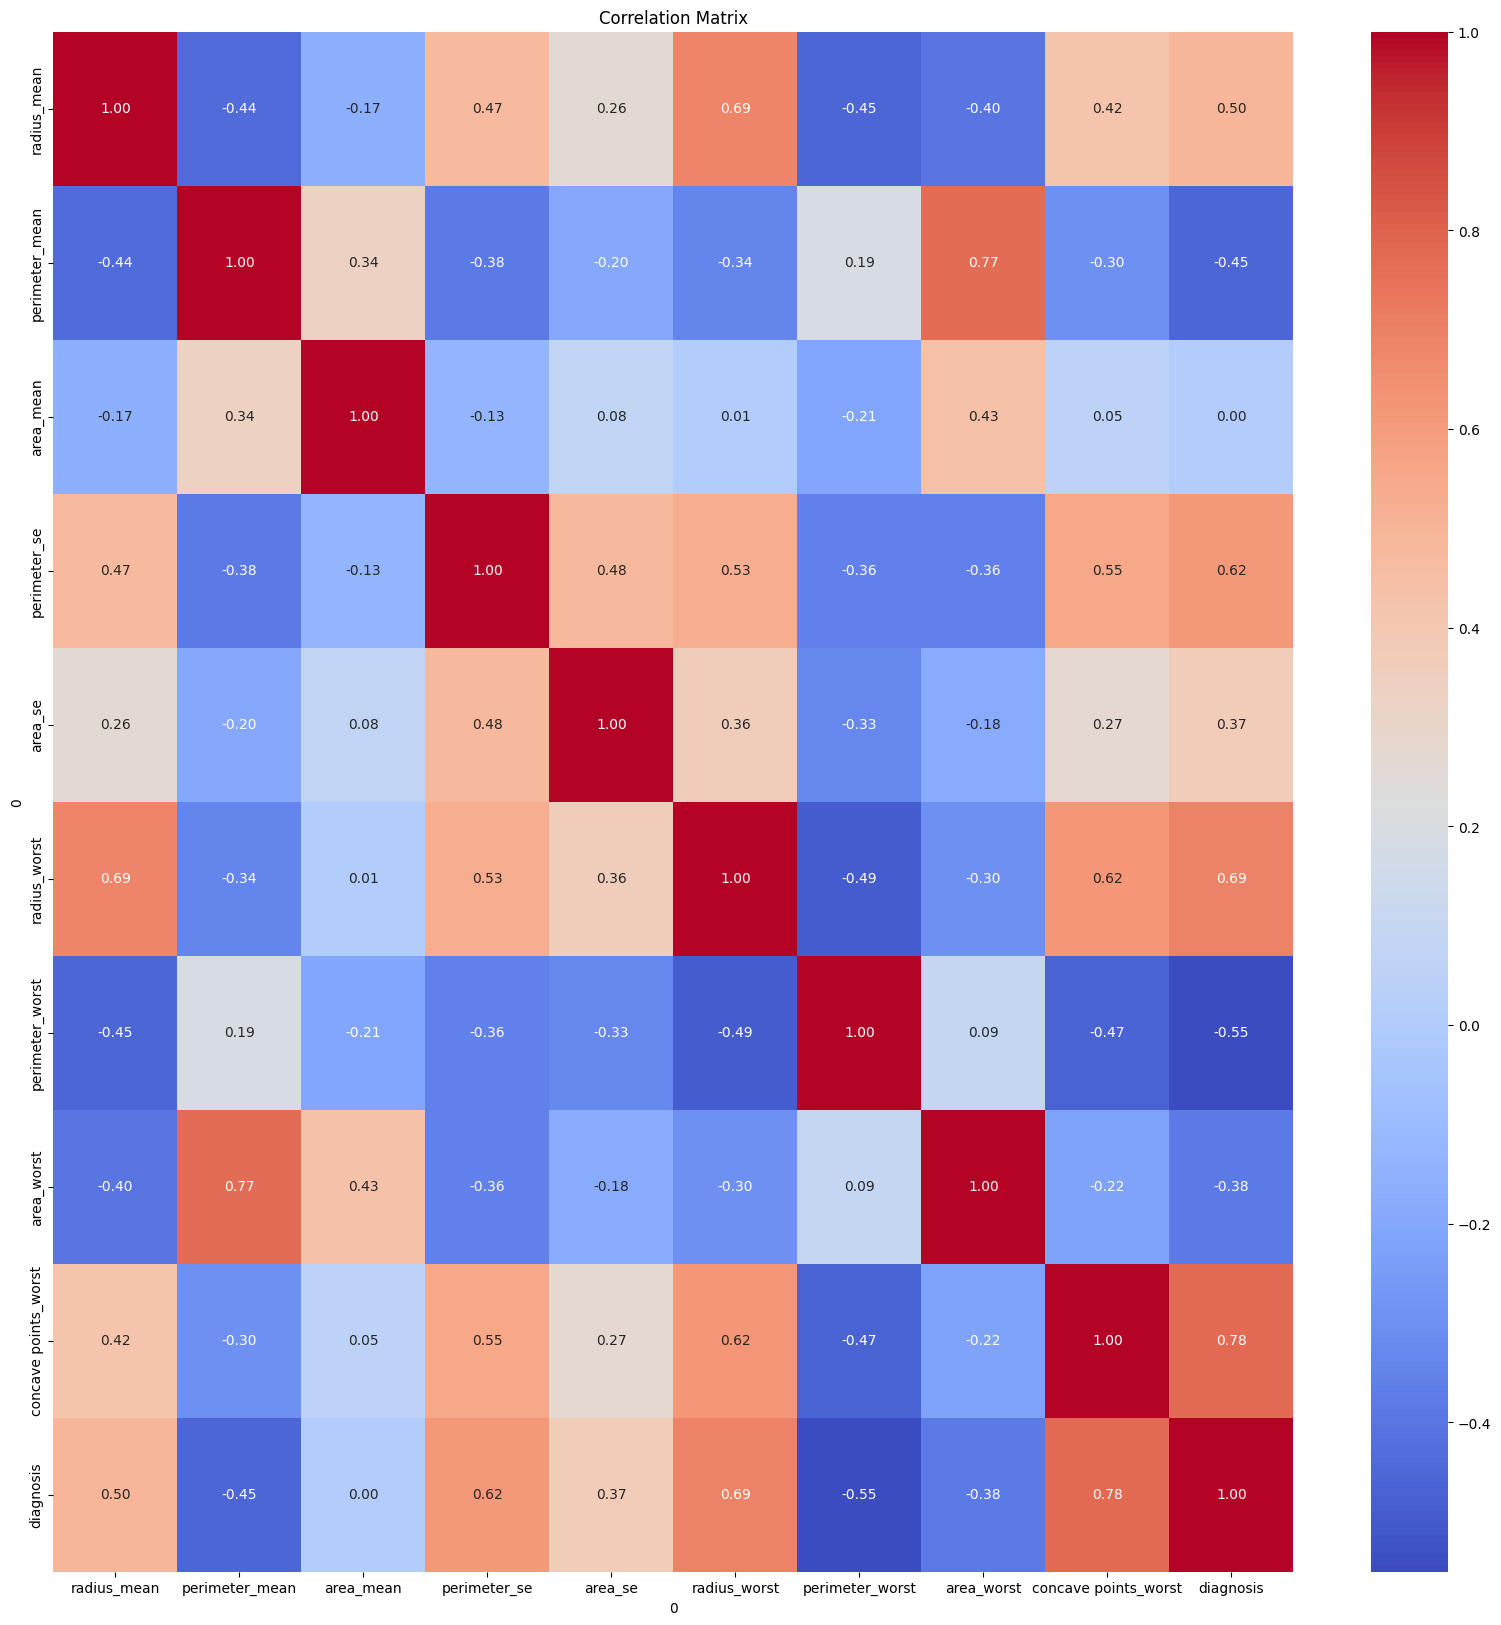

In [39]:
anlyzr.perform_filter_methods()
anlyzr.show_heat_map()

In [ ]:
anlyzr.show_boxplots()

In [ ]:
from sklearn.decomposition import PCA


X, y = anlyzr.get_x_and_Y()
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()